In [25]:
import os
import copy
import pandas as pd
import numpy as np
from experiments import ExperimentModule
from experiments import (
    save_plots, 
    write_row, 
    write_opcounts,
    load_circuit,
    load_qasm_circuit,
    create_dir,
    get_random_state
)
from sanchez_ansatz import SanchezAnsatz
from qiskit import transpile
from experiments.create_state import get_state
import matplotlib.pyplot as plt
from itertools import product
from datetime import datetime
from typing import Tuple
from qiskit_aer import Aer

%matplotlib inline

In [26]:
results_dir = "results/runs_shell_w_entanglement/distributions"
run_range = list(range(1, 11))
#qubit_range = [3, 4, 5, 6, 7, 8]
qubit_range = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

# EPS values are mapped separately
#eps_values = [0.5, 0.1, 0.05, 0.01, 0.005, 0.001]
eps_values = [0.5, 0.1, 0.05, 0.01]

In [27]:
def load_results(results_dir, state_type, qubit_range, eps_values) -> Tuple[dict,dict]:
    #[0.5, 0.1, 0.05, 0.01, 0.005, 0.001]
    original_results_dict = {
        "num_qubits": [],
        0.5: [],
        0.1: [],
        0.05: [],
        0.01: [],
    }

    modified_results_dict = copy.deepcopy(original_results_dict)

    for (r_dir, st_type, num_qubits, eps) in product([results_dir], [state_type], qubit_range, eps_values):
        if not num_qubits in original_results_dict["num_qubits"]: 
            original_results_dict["num_qubits"] += [num_qubits]
            modified_results_dict["num_qubits"] += [num_qubits]

        original_results_dict[eps] += [[]]
        modified_results_dict[eps] += [[]]

        for run_idx in run_range:
            fid_loss_original = np.loadtxt(f"{results_dir}/{st_type}/run_{run_idx}/csv/original_fidloss_{num_qubits}qb_{eps}eps.csv", delimiter=",")
            data_original = fid_loss_original[-1][-1] if len(fid_loss_original.shape) > 1 else fid_loss_original[-1]
            original_results_dict[eps][-1] += [data_original.round(4)]

            fid_loss_modified = np.loadtxt(f"{results_dir}/{st_type}/run_{run_idx}/csv/modified_fidloss_{num_qubits}qb_{eps}eps.csv", delimiter=",")
            data_modified = fid_loss_modified[-1][-1] if len(fid_loss_modified.shape) > 1 else fid_loss_modified[-1]
            modified_results_dict[eps][-1]+= [data_modified.round(4)]
    
    return original_results_dict, modified_results_dict


def compute_statistics(results_dict: dict) -> Tuple[dict, dict]: 
    default_dict = {
        "num_qubits": qubit_range,
        0.5: [],
        0.1: [],
        0.05: [],
        0.01: [],
    }
    mean_results_dict = copy.deepcopy(default_dict)
    stds_results_dict = copy.deepcopy(default_dict)

    #stds_original_results_dict = copy.deepcopy(default_dict)
    #stds_modified_results_dict = copy.deepcopy(default_dict)

    for eps in eps_values:
        mean_results_dict[eps] = np.mean(results_dict[eps], axis=1)
        stds_results_dict[eps] = np.std(results_dict[eps], axis=1).round(2)

        #mean_modified_results_dict[eps] = np.mean(modified_results_dict[eps], axis=1)
        #stds_modified_results_dict[eps] = np.std(modified_results_dict[eps], axis=1).round(2)
    return mean_results_dict, stds_results_dict


def to_dataframe(results_dict: dict) -> pd.DataFrame:
    df_results = pd.DataFrame(results_dict)
    df_results = df_results.set_index("num_qubits")
    return df_results

def get_state_vector(quantum_circuit):
    sv_sim = Aer.get_backend("statevector_simulator")
    job = sv_sim.run(quantum_circuit)
    result = job.result()
    state_vector = result.get_statevector()
    return state_vector.data

def get_loaded_states(results_dir, state_type, execution_range, n_qubits, eps_value) -> Tuple[np.ndarray, np.ndarray]:

    sv_list_original = []
    sv_list_modified = []

    for n_run in range(1, execution_range+1):
        # original_circuit_file_name = os.path.join(results_dir, state_type, f"run_{n_run}", "circuits", f"original_curcuit_{n_qubits}qb_{eps_value}eps.pkl")
        # original_circuit = load_circuit(original_circuit_file_name)
        original_circuit_file_name = os.path.join(results_dir, state_type, f"run_{n_run}", "circuits", f"original_curcuit_{n_qubits}qb_{eps_value}eps.qasm")
        original_circuit = load_qasm_circuit(original_circuit_file_name)

        # Because we are now loading qasm circuits we do not need to assign all parameters
        # parameters_original_filename = os.path.join(results_dir, state_type, f"run_{n_run}", "csv", f"original_xbest_{n_qubits}qb_{eps_value}eps.csv")
        # parameters_original = np.loadtxt(parameters_original_filename, delimiter=",")


        # modified_circuit_file_name = os.path.join(results_dir, state_type, "run_10", "circuits", f"modified_curcuit_{n_qubits}qb_{eps_value}eps.pkl")
        # modified_circuit = load_circuit(modified_circuit_file_name)
        modified_circuit_file_name = os.path.join(results_dir, state_type, "run_10", "circuits", f"modified_curcuit_{n_qubits}qb_{eps_value}eps.qasm")
        modified_circuit = load_qasm_circuit(modified_circuit_file_name)

        # Because we are now loading qasm circuits we do not need to assign all parameters
        # parameters_modified_filename = os.path.join(results_dir, state_type, f"run_{n_run}", "csv", f"modified_xbest_{n_qubits}qb_{eps_value}eps.csv")
        # parameters_modified = np.loadtxt(parameters_modified_filename, delimiter=",")

        # p_original_circuit = original_circuit.assign_parameters(parameters_original)
        # sv_original = get_state_vector(p_original_circuit)
        sv_original = get_state_vector(original_circuit)
        sv_list_original += [sv_original]

        # p_modified_circuit = modified_circuit.assign_parameters(parameters_modified)
        # sv_modified = get_state_vector(p_modified_circuit)
        sv_modified = get_state_vector(modified_circuit)
        sv_list_modified += [sv_modified]

    sv_mean_original = np.mean(sv_list_original, axis=0)
    sv_std_original  = np.std(sv_list_original, axis=0)

    sv_mean_modified = np.mean(sv_list_modified, axis=0)
    sv_std_modified  = np.std(sv_list_original, axis=0)

    return (sv_mean_original, sv_std_original), (sv_mean_modified, sv_std_modified)

### Normal distribution $(\mu = 0.5, \sigma = 0.3)$

In [28]:
state_type = "normal"

In [29]:
original_results_dict, modified_results_dict = load_results(results_dir, state_type, qubit_range, eps_values)

mean_original_results_dict, stds_original_results_dict = compute_statistics(original_results_dict)
mean_modified_results_dict, stds_modified_results_dict = compute_statistics(modified_results_dict)

df_mean_original = to_dataframe(mean_original_results_dict)
df_stds_original = to_dataframe(stds_modified_results_dict)

df_mean_modified = to_dataframe(mean_modified_results_dict)
df_stds_modified = to_dataframe(stds_modified_results_dict)

In [30]:
display(df_mean_original)
display(df_mean_modified)

,0.5,0.1,0.05,0.01
num_qubits,,,,
3,0.0244,0.02440,0.00000,0.00000
4,0.0270,0.02700,0.00560,0.00061
5,0.0263,0.02630,0.00647,0.00401
6,0.0256,0.02560,0.00650,0.01610
7,0.0252,0.02520,0.00640,0.00262
8,0.0250,0.02500,0.00640,0.00254
9,0.0249,0.02490,0.00640,0.00507
10,0.0249,0.02490,0.10559,0.00258
11,0.1223,0.02480,0.10576,0.00278


,0.5,0.1,0.05,0.01
num_qubits,,,,
3,0.02650,0.02650,0.85889,0.89960
4,0.02750,0.02750,0.00561,0.93537
5,0.02650,0.02650,0.75030,0.00553
6,0.02580,0.02580,0.00650,0.75010
7,0.02530,0.02530,0.50320,0.00198
8,0.02510,0.02510,0.00640,0.00211
9,0.12250,0.02500,0.00740,0.07228
10,0.12610,0.12241,0.20504,0.75130
11,0.02490,0.02490,0.75160,0.00197


In [31]:
df_mean_original < df_mean_modified

,0.5,0.1,0.05,0.01
num_qubits,,,,
3,True,True,True,True
4,True,True,True,True
5,True,True,True,True
6,True,True,False,True
7,True,True,True,False
8,True,True,False,False
9,True,True,True,True
10,True,True,True,True
11,False,True,True,False


In [32]:
n_qubits = 15
eps_value = 0.05
execution_range = 10

(sv_mean_original, sv_std_original), (sv_mean_modified, sv_std_modified) = get_loaded_states(results_dir=results_dir, state_type=state_type, execution_range=execution_range, n_qubits=n_qubits, eps_value=eps_value)

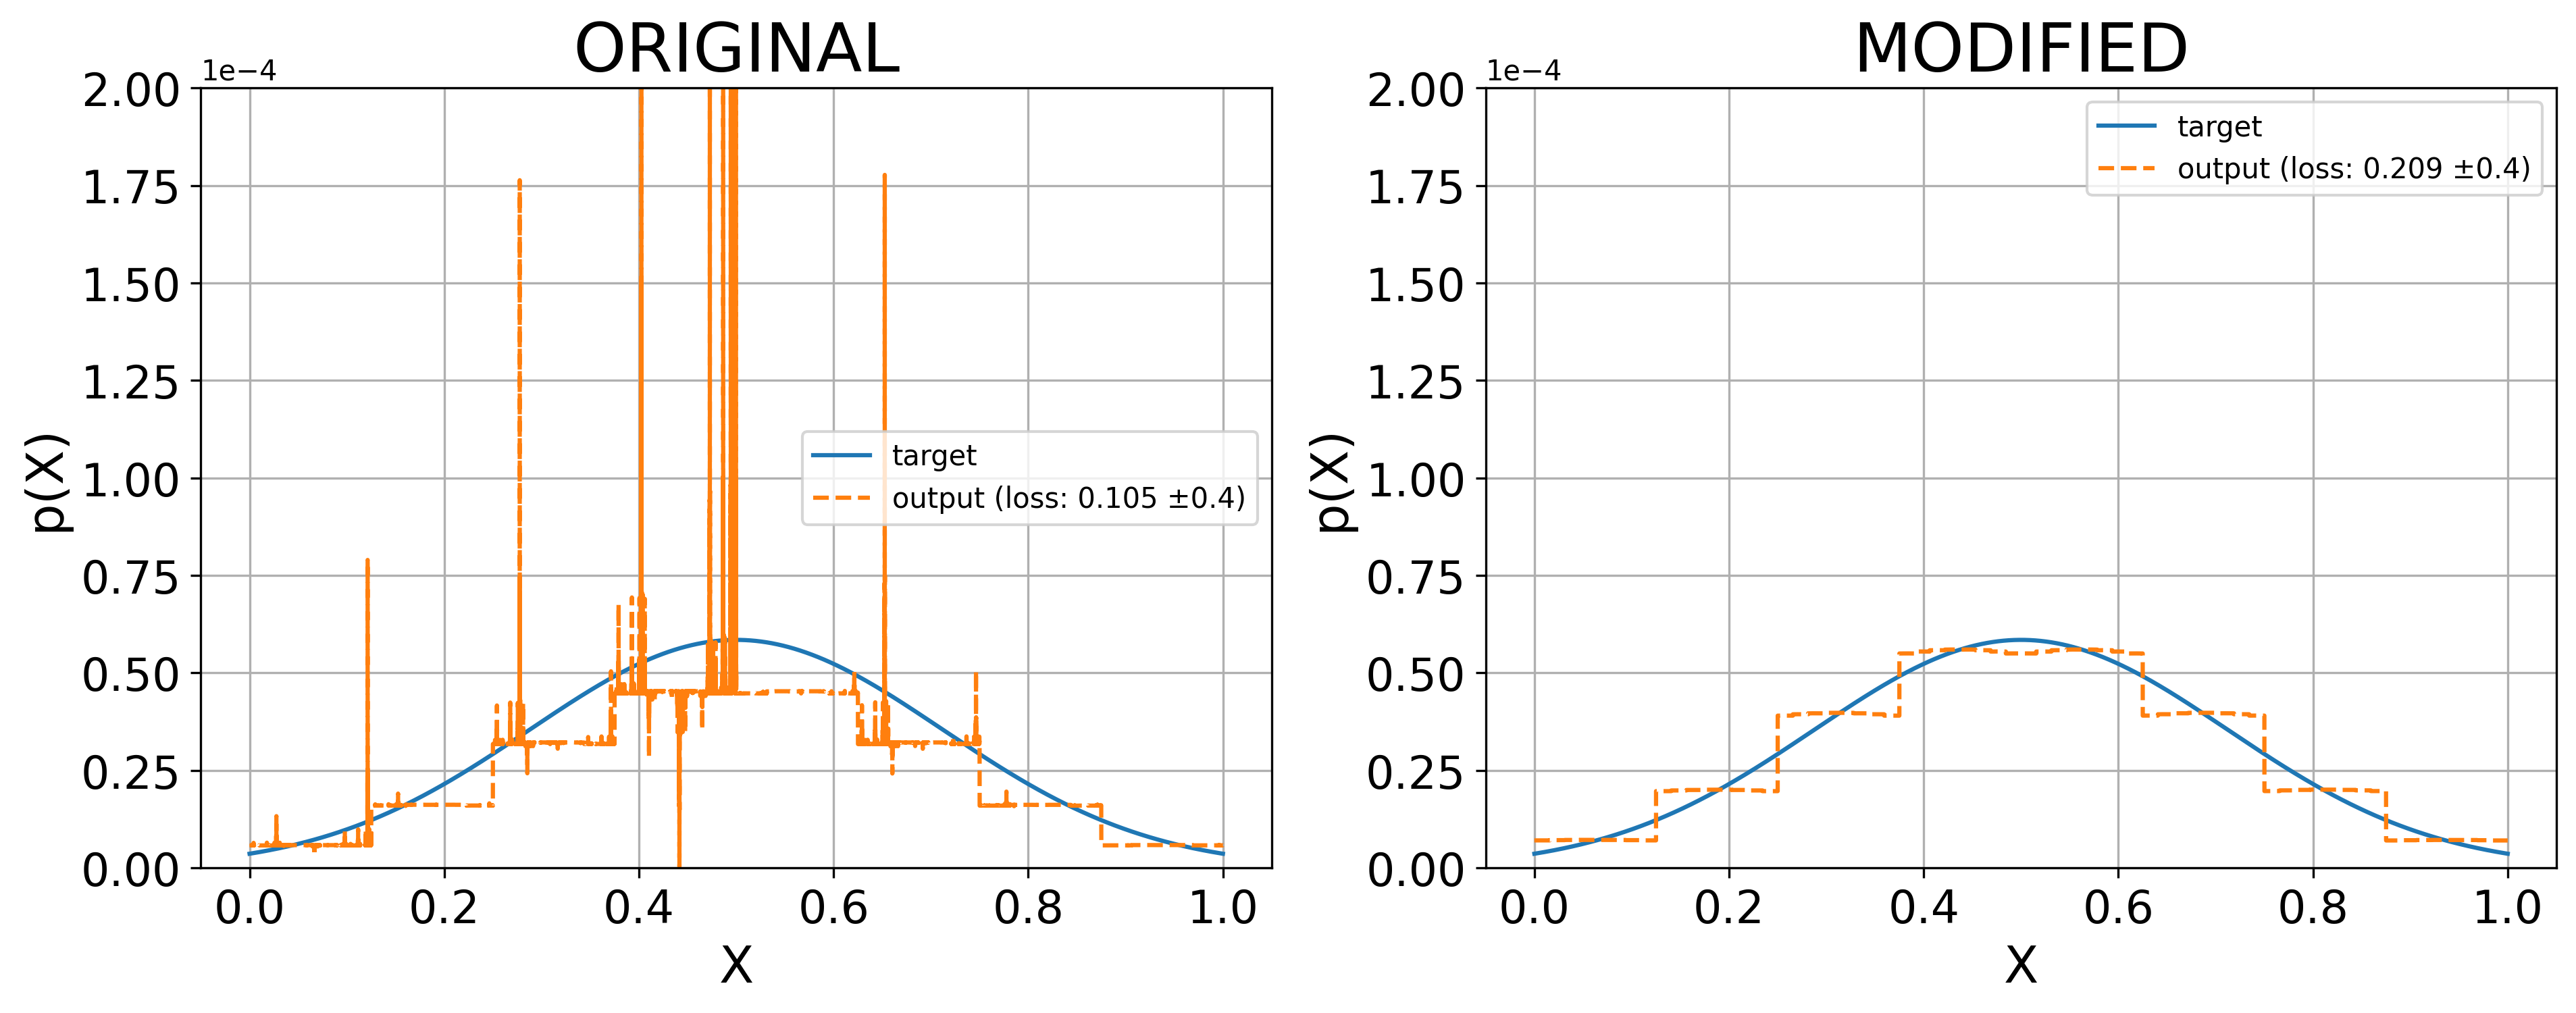

In [33]:
target_state = get_state(num_qubits=n_qubits, state_type=state_type, state_params={"x_points": (0, 1), "loc": 0.5, "scale": 0.3})


x_points = np.linspace(0, 1, 2**n_qubits)

target_freqs = np.abs(target_state)**2

#plt.ticklabel_format(axis="y", style="sci")
fig, axes = plt.subplots(1, 2, dpi=300)
fig.set_figheight(5)
fig.set_figwidth(15)
title_fontsize = 24
labels_fontsize= 18
ticks_fontsize = 16
axes[0].set_title("ORIGINAL", fontsize=title_fontsize)
axes[0].plot(x_points, target_freqs, label="target")
axes[0].plot(x_points, np.abs(sv_mean_original)**2, "--", label=f"output (loss: {round(df_mean_original.loc[n_qubits][eps_value], 3)} ±{round(df_stds_original.loc[n_qubits][eps_value], 2)})")
axes[0].grid()
axes[0].set_xlabel("X", fontsize=labels_fontsize)
axes[0].set_ylabel("p(X)", fontsize=labels_fontsize)
axes[0].tick_params(labelsize=ticks_fontsize)
axes[0].set_ylim([0, 0.0002])
axes[0].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
axes[0].legend(loc="best")

axes[1].set_title("MODIFIED", fontsize=title_fontsize)
axes[1].plot(x_points, target_freqs, label="target")
axes[1].plot(x_points, np.abs(sv_mean_modified)**2, "--", label=f"output (loss: {round(df_mean_modified.loc[n_qubits][eps_value], 3)} ±{round(df_stds_modified.loc[n_qubits][eps_value], 2)})")
axes[1].grid()
axes[1].set_xlabel("X", fontsize=labels_fontsize)
axes[1].set_ylabel("p(X)", fontsize=labels_fontsize)
axes[1].tick_params(labelsize=ticks_fontsize)
axes[1].set_ylim([0, 0.0002])
axes[1].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
axes[1].legend(loc="best")

### $log$-Normal Distribution $(s= 1, \mu = 0.1, \sigma = 0.3)$

In [34]:
state_type = "lognormal"

In [35]:
original_results_dict, modified_results_dict = load_results(results_dir, state_type, qubit_range, eps_values)

mean_original_results_dict, stds_original_results_dict = compute_statistics(original_results_dict)
mean_modified_results_dict, stds_modified_results_dict = compute_statistics(modified_results_dict)

df_mean_original = to_dataframe(mean_original_results_dict)
df_stds_original = to_dataframe(stds_modified_results_dict)

df_mean_modified = to_dataframe(mean_modified_results_dict)
df_stds_modified = to_dataframe(stds_modified_results_dict)

In [36]:
display(df_mean_original)
display(df_mean_modified)

,0.5,0.1,0.05,0.01
num_qubits,,,,
3,0.08100,0.08100,0.00293,0.00080
4,0.12870,0.12870,0.03581,0.00581
5,0.13130,0.13130,0.03162,0.01763
6,0.12650,0.12650,0.02648,0.03087
7,0.12360,0.12360,0.02540,0.01524
8,0.12210,0.12210,0.02391,0.01620
9,0.12130,0.12130,0.02445,0.02783
10,0.12090,0.12090,0.02357,0.02035
11,0.12070,0.12071,0.02401,0.01555


,0.5,0.1,0.05,0.01
num_qubits,,,,
3,0.15460,0.15460,0.90983,0.90696
4,0.21110,0.21110,0.04031,0.96979
5,0.22210,0.22210,0.77223,0.02237
6,0.21940,0.21940,0.02848,0.75424
7,0.21710,0.21710,0.51490,0.01575
8,0.21570,0.21570,0.02571,0.02613
9,0.21500,0.21500,0.11954,0.11562
10,0.21460,0.21460,0.12154,0.75396
11,0.21440,0.21441,0.78064,0.12404


In [37]:
df_mean_original < df_mean_modified

,0.5,0.1,0.05,0.01
num_qubits,,,,
3,True,True,True,True
4,True,True,True,True
5,True,True,True,True
6,True,True,True,True
7,True,True,True,True
8,True,True,True,True
9,True,True,True,True
10,True,True,True,True
11,True,True,True,True


In [38]:
n_qubits = 15
eps_value = 0.01
execution_range = 10

(sv_mean_original, sv_std_original), (sv_mean_modified, sv_std_modified) = get_loaded_states(results_dir=results_dir, state_type=state_type, execution_range=execution_range, n_qubits=n_qubits, eps_value=eps_value)

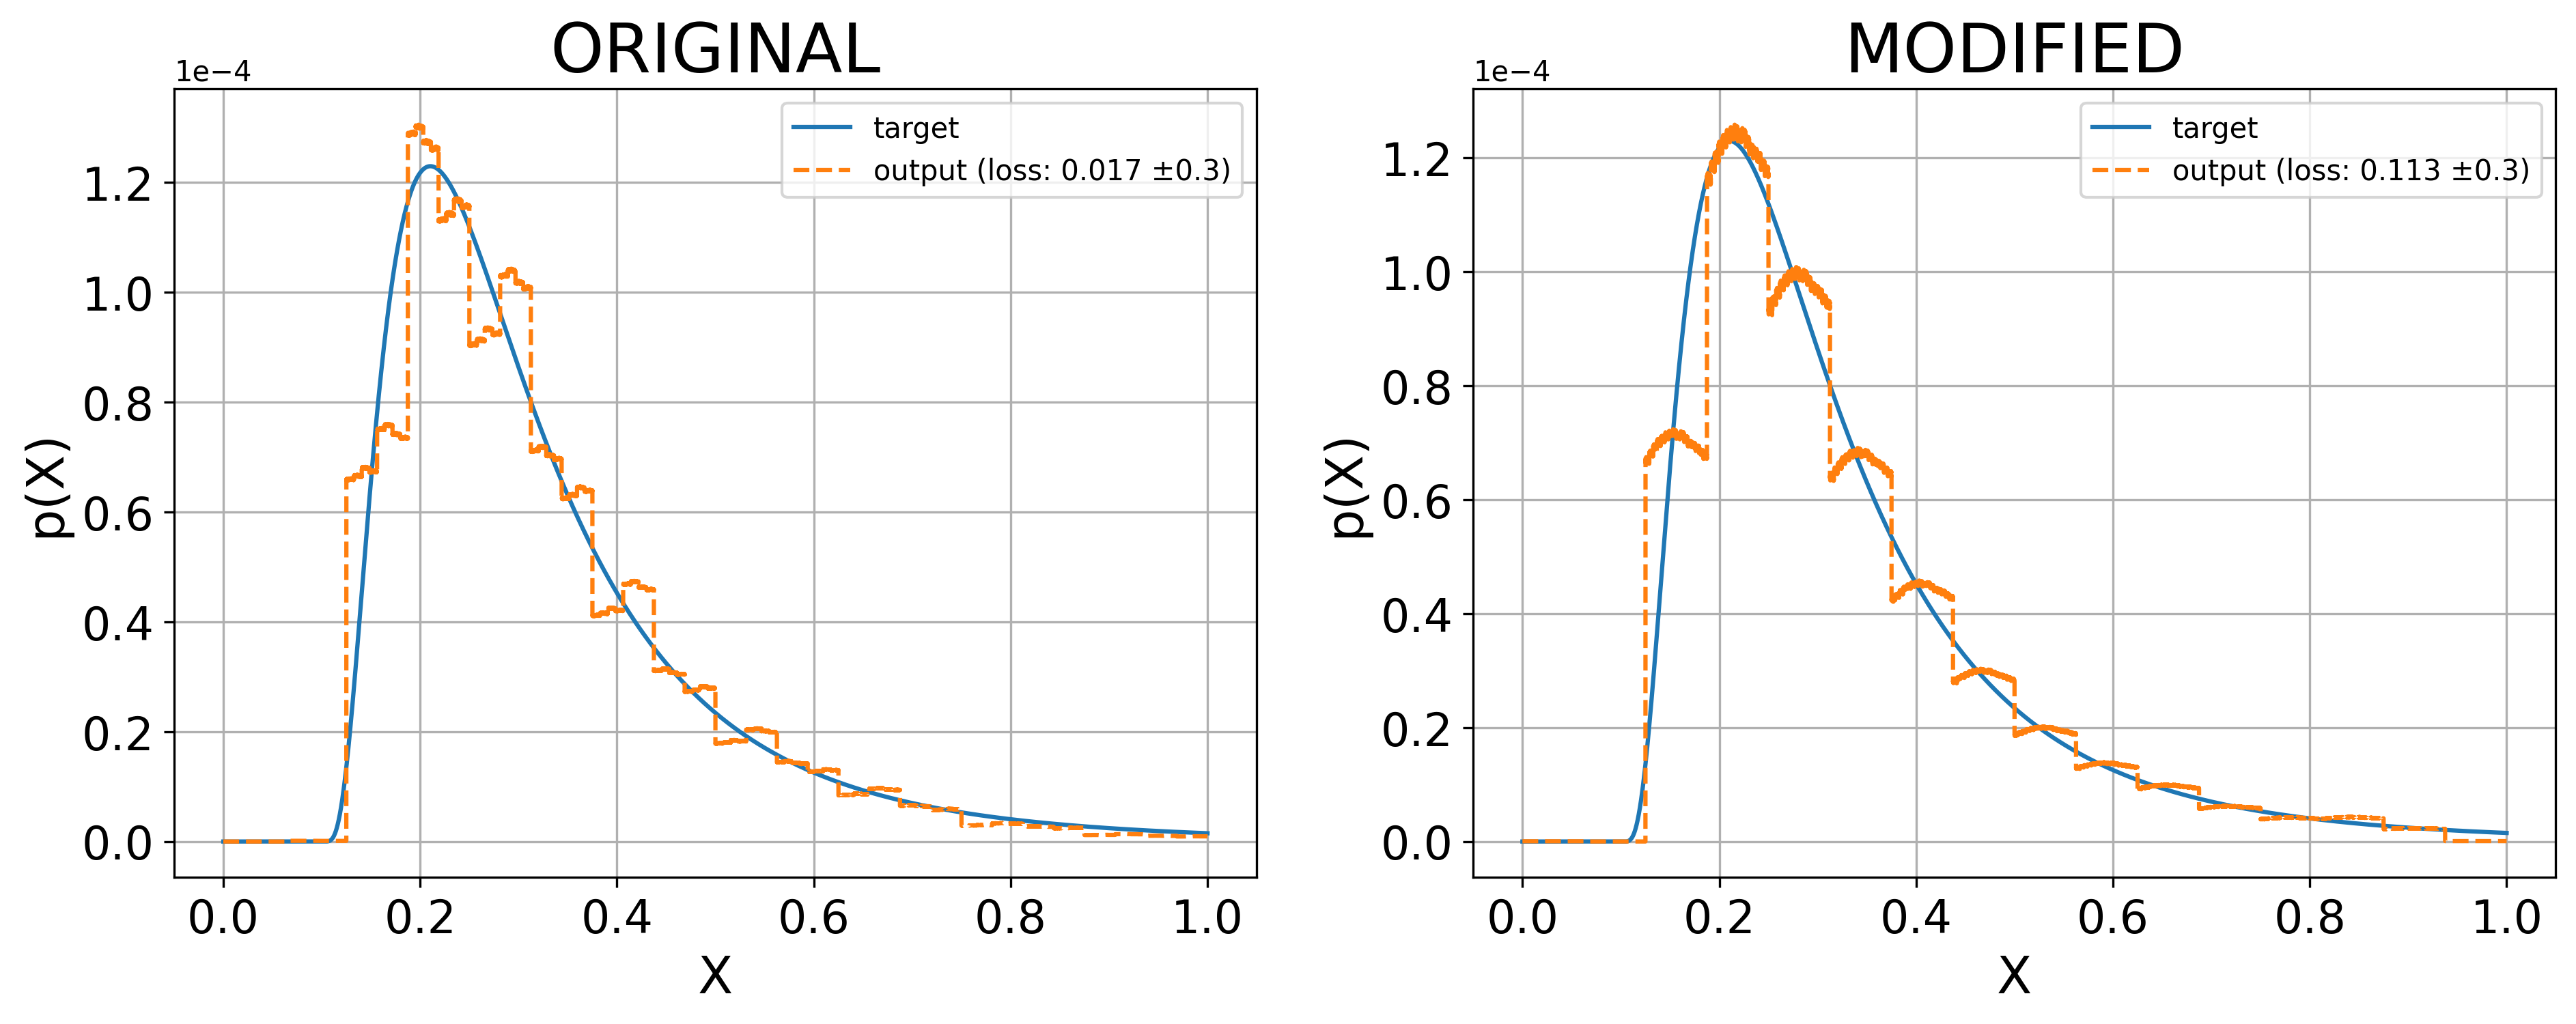

In [39]:
target_state = get_state(num_qubits=n_qubits, state_type=state_type, state_params={"x_points": (0, 1), "s": 1, "loc": 0.1, "scale": 0.3})


x_points = np.linspace(0, 1, 2**n_qubits)


target_freqs = np.abs(target_state)**2

#plt.ticklabel_format(axis="y", style="sci")
fig, axes = plt.subplots(1, 2, dpi=300)
fig.set_figheight(5)
fig.set_figwidth(15)
title_fontsize = 24
labels_fontsize= 18
ticks_fontsize = 16
axes[0].set_title("ORIGINAL", fontsize=title_fontsize)
axes[0].plot(x_points, target_freqs, label="target")
axes[0].plot(x_points, np.abs(sv_mean_original)**2, "--", label=f"output (loss: {round(df_mean_original.loc[n_qubits][eps_value], 3)} ±{round(df_stds_original.loc[n_qubits][eps_value], 2)})")
axes[0].grid()
axes[0].set_xlabel("X", fontsize=labels_fontsize)
axes[0].set_ylabel("p(X)", fontsize=labels_fontsize)
axes[0].tick_params(labelsize=ticks_fontsize)
#axes[0].set_ylim([0, 0.0002])
axes[0].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
axes[0].legend(loc="best")

axes[1].set_title("MODIFIED", fontsize=title_fontsize)
axes[1].plot(x_points, target_freqs, label="target")
axes[1].plot(x_points, np.abs(sv_mean_modified)**2, "--", label=f"output (loss: {round(df_mean_modified.loc[n_qubits][eps_value], 3)} ±{round(df_stds_modified.loc[n_qubits][eps_value], 2)})")
axes[1].grid()
axes[1].set_xlabel("X", fontsize=labels_fontsize)
axes[1].set_ylabel("p(X)", fontsize=labels_fontsize)
axes[1].tick_params(labelsize=ticks_fontsize)
#axes[1].set_ylim([0, 0.0002])
axes[1].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
axes[1].legend(loc="best")

### Bimodal Distribution $(\mu_1 = 0.25, \sigma_1 = 0.1; \mu_2 = 0.75, \sigma_2 = 0.15)$

In [40]:
state_type = "bimodal"

In [41]:
original_results_dict, modified_results_dict = load_results(results_dir, state_type, qubit_range, eps_values)

mean_original_results_dict, stds_original_results_dict = compute_statistics(original_results_dict)
mean_modified_results_dict, stds_modified_results_dict = compute_statistics(modified_results_dict)

df_mean_original = to_dataframe(mean_original_results_dict)
df_stds_original = to_dataframe(stds_modified_results_dict)

df_mean_modified = to_dataframe(mean_modified_results_dict)
df_stds_modified = to_dataframe(stds_modified_results_dict)

In [42]:
display(df_mean_original)
display(df_mean_modified)

,0.5,0.1,0.05,0.01
num_qubits,,,,
3,0.0307,0.03070,0.00000,0.00001
4,0.0612,0.06120,0.03260,0.00373
5,0.0631,0.06310,0.03725,0.01344
6,0.0621,0.06210,0.03780,0.01826
7,0.0612,0.06120,0.03762,0.02166
8,0.0607,0.06070,0.03780,0.01806
9,0.0604,0.06040,0.03733,0.15273
10,0.0602,0.06020,0.03730,0.03014
11,0.0601,0.06010,0.13349,0.02028


,0.5,0.1,0.05,0.01
num_qubits,,,,
3,0.15370,0.15370,0.89674,0.94737
4,0.19250,0.19250,0.03350,0.96207
5,0.19300,0.19300,0.75150,0.01651
6,0.19050,0.19050,0.03800,0.75168
7,0.18870,0.18870,0.51904,0.01592
8,0.18770,0.18770,0.03760,0.02655
9,0.18720,0.18720,0.03741,0.01136
10,0.18690,0.18690,0.03740,0.75332
11,0.26812,0.18680,0.75940,0.10998


In [43]:
display(df_stds_original)
display(df_stds_modified)

,0.5,0.1,0.05,0.01
num_qubits,,,,
3,0.00,0.00,0.12,0.12
4,0.00,0.00,0.00,0.03
5,0.00,0.00,0.00,0.01
6,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.01
8,0.00,0.00,0.00,0.04
9,0.00,0.00,0.00,0.00
10,0.00,0.00,0.00,0.00
11,0.24,0.00,0.00,0.29


,0.5,0.1,0.05,0.01
num_qubits,,,,
3,0.00,0.00,0.12,0.12
4,0.00,0.00,0.00,0.03
5,0.00,0.00,0.00,0.01
6,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.01
8,0.00,0.00,0.00,0.04
9,0.00,0.00,0.00,0.00
10,0.00,0.00,0.00,0.00
11,0.24,0.00,0.00,0.29


In [44]:
df_mean_original < df_mean_modified

,0.5,0.1,0.05,0.01
num_qubits,,,,
3,True,True,True,True
4,True,True,True,True
5,True,True,True,True
6,True,True,True,True
7,True,True,True,False
8,True,True,False,True
9,True,True,True,False
10,True,True,True,True
11,True,True,True,True


In [45]:
n_qubits = 15
eps_value = 0.01
execution_range = 10

(sv_mean_original, sv_std_original), (sv_mean_modified, sv_std_modified) = get_loaded_states(results_dir=results_dir, state_type=state_type, execution_range=execution_range, n_qubits=n_qubits, eps_value=eps_value)

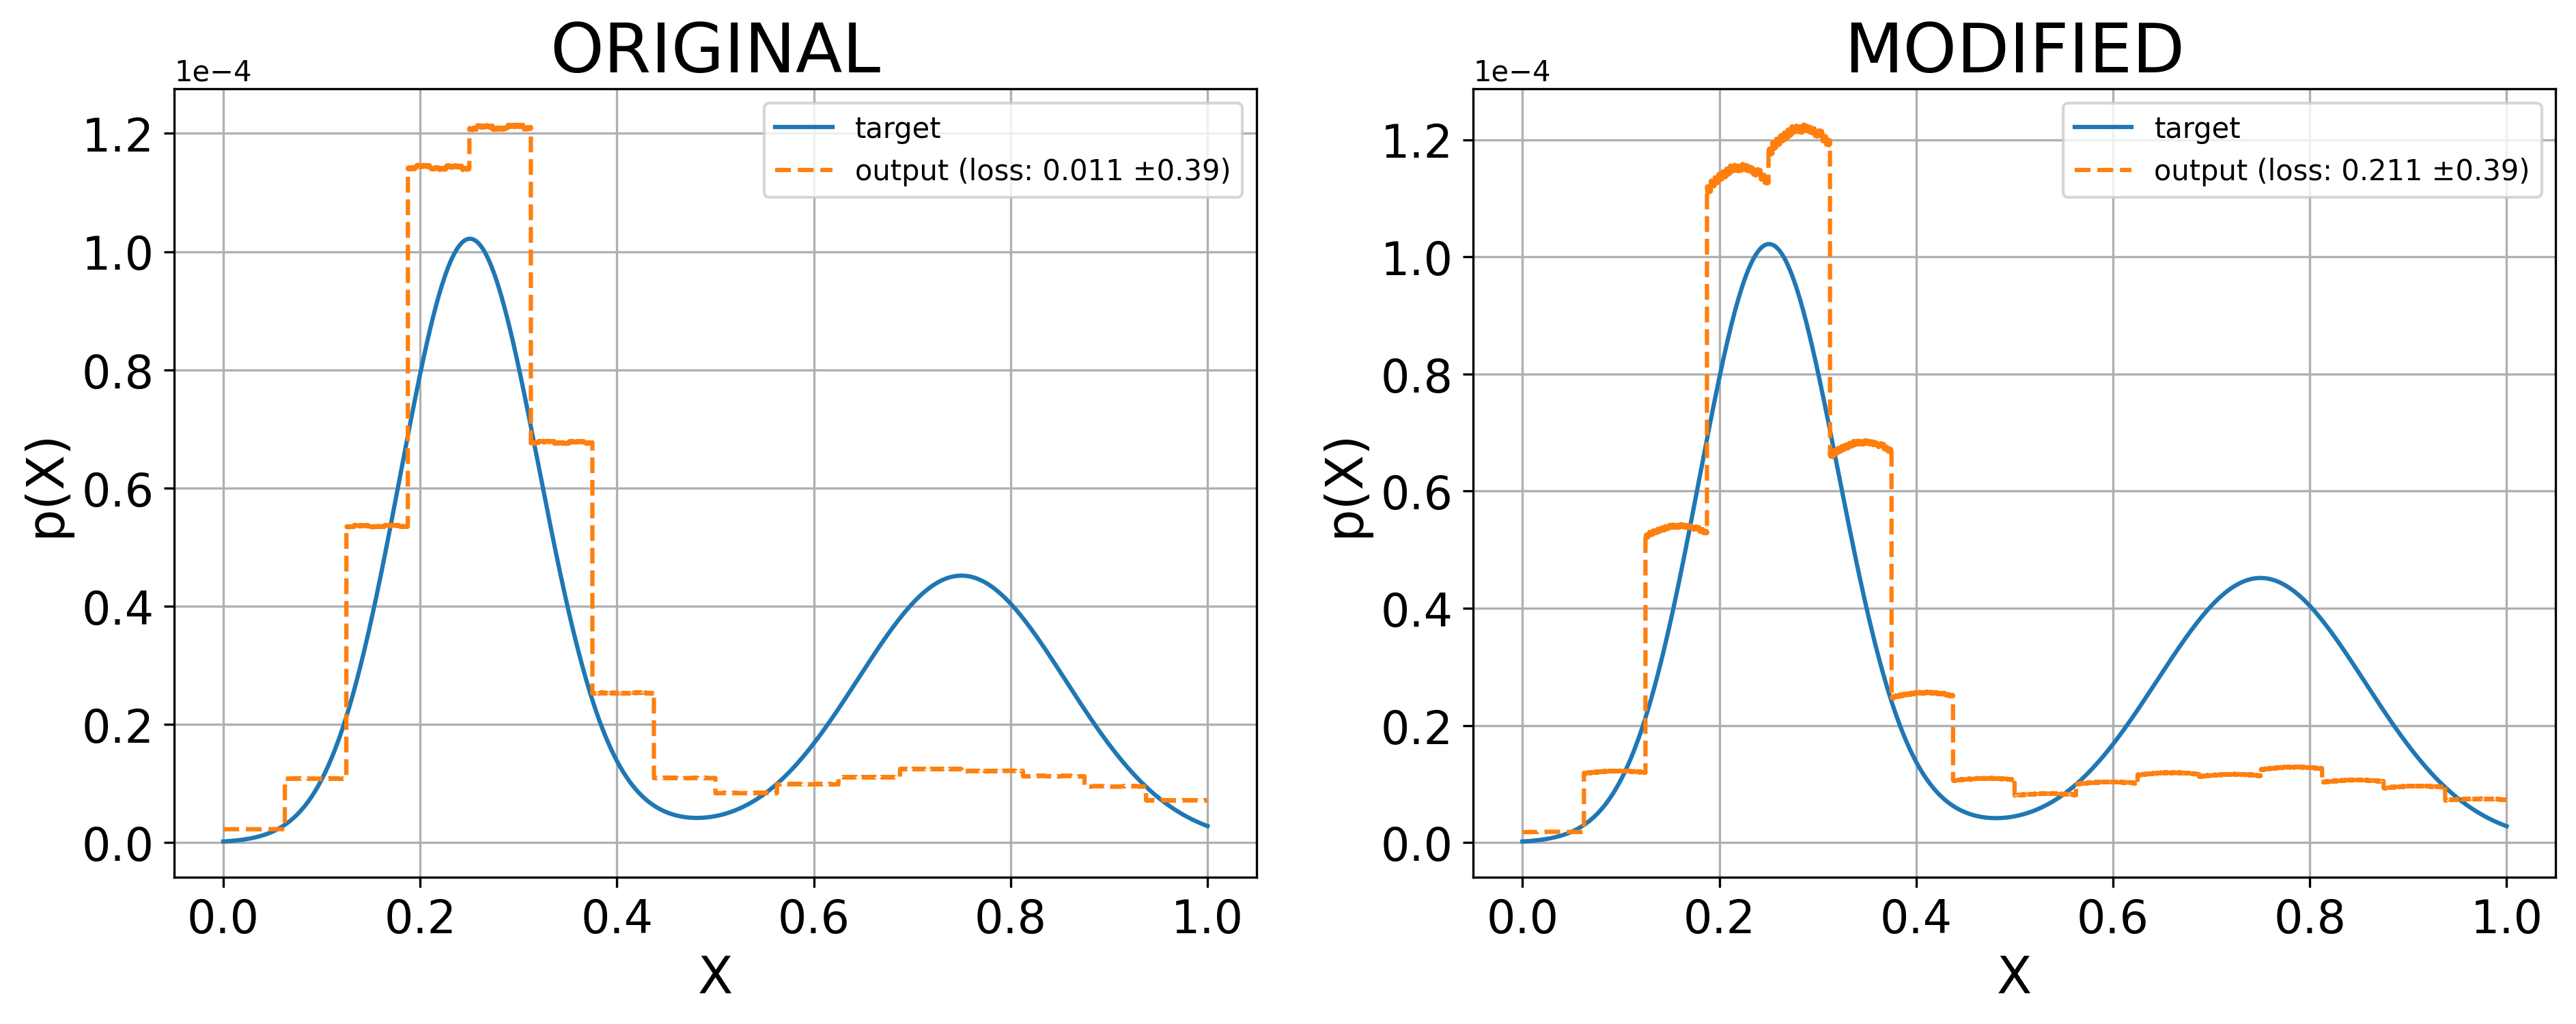

In [46]:
target_state = get_state(num_qubits=n_qubits, state_type=state_type, state_params={"x_points": (0, 1), "loc_bim1": 0.25, "scale_bim1": 0.1, "loc_bim2": 0.75, "scale_bim2": 0.15})


x_points = np.linspace(0, 1, 2**n_qubits)

target_freqs = np.abs(target_state)**2

#plt.ticklabel_format(axis="y", style="sci")
fig, axes = plt.subplots(1, 2, dpi=300)
fig.set_figheight(5)
fig.set_figwidth(15)
title_fontsize = 24
labels_fontsize= 18
ticks_fontsize = 16
axes[0].set_title("ORIGINAL", fontsize=title_fontsize)
axes[0].plot(x_points, target_freqs, label="target")
axes[0].plot(x_points, np.abs(sv_mean_original)**2, "--", label=f"output (loss: {round(df_mean_original.loc[n_qubits][eps_value], 3)} ±{round(df_stds_original.loc[n_qubits][eps_value], 2)})")
axes[0].grid()
axes[0].set_xlabel("X", fontsize=labels_fontsize)
axes[0].set_ylabel("p(X)", fontsize=labels_fontsize)
axes[0].tick_params(labelsize=ticks_fontsize)
#axes[0].set_ylim([0, 0.0002])
axes[0].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
axes[0].legend(loc="best")

axes[1].set_title("MODIFIED", fontsize=title_fontsize)
axes[1].plot(x_points, target_freqs, label="target")
axes[1].plot(x_points, np.abs(sv_mean_modified)**2, "--", label=f"output (loss: {round(df_mean_modified.loc[n_qubits][eps_value], 3)} ±{round(df_stds_modified.loc[n_qubits][eps_value], 2)})")
axes[1].grid()
axes[1].set_xlabel("X", fontsize=labels_fontsize)
axes[1].set_ylabel("p(X)", fontsize=labels_fontsize)
axes[1].tick_params(labelsize=ticks_fontsize)
#axes[1].set_ylim([0, 0.0002])
axes[1].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
axes[1].legend(loc="best")

### Laplace $(\mu = 0.5, \sigma = 0.2)$

In [47]:
state_type = "laplace"

In [48]:
original_results_dict, modified_results_dict = load_results(results_dir, state_type, qubit_range, eps_values)

mean_original_results_dict, stds_original_results_dict = compute_statistics(original_results_dict)
mean_modified_results_dict, stds_modified_results_dict = compute_statistics(modified_results_dict)

df_mean_original = to_dataframe(mean_original_results_dict)
df_stds_original = to_dataframe(stds_modified_results_dict)

df_mean_modified = to_dataframe(mean_modified_results_dict)
df_stds_modified = to_dataframe(stds_modified_results_dict)

In [49]:
display(df_mean_original)
display(df_mean_modified)

,0.5,0.1,0.05,0.01
num_qubits,,,,
3,0.0197,0.01970,0.00302,0.00253
4,0.0471,0.04710,0.02714,0.00715
5,0.0520,0.05200,0.03316,0.01712
6,0.0528,0.05280,0.03733,0.02333
7,0.0528,0.05280,0.03166,0.01723
8,0.0527,0.05270,0.03238,0.01627
9,0.0526,0.05260,0.03301,0.11574
10,0.0526,0.05260,0.03256,0.01392
11,0.0526,0.05260,0.22525,0.11558


,0.5,0.1,0.05,0.01
num_qubits,,,,
3,0.10510,0.10510,0.94786,0.86552
4,0.11530,0.11530,0.02676,0.97982
5,0.11490,0.11490,0.73771,0.01274
6,0.11320,0.11320,0.03178,0.74896
7,0.11200,0.11200,0.51575,0.01323
8,0.11140,0.11140,0.03675,0.01547
9,0.11100,0.11100,0.03206,0.01239
10,0.11090,0.28442,0.03220,0.75417
11,0.11080,0.11080,0.78217,0.23032


In [50]:
df_mean_original < df_mean_modified

,0.5,0.1,0.05,0.01
num_qubits,,,,
3,True,True,True,True
4,True,True,False,True
5,True,True,True,False
6,True,True,False,True
7,True,True,True,False
8,True,True,True,False
9,True,True,False,False
10,True,True,False,True
11,True,True,True,True


In [51]:
n_qubits = 15
eps_value = 0.01
execution_range = 10

(sv_mean_original, sv_std_original), (sv_mean_modified, sv_std_modified) = get_loaded_states(results_dir=results_dir, state_type=state_type, execution_range=execution_range, n_qubits=n_qubits, eps_value=eps_value)

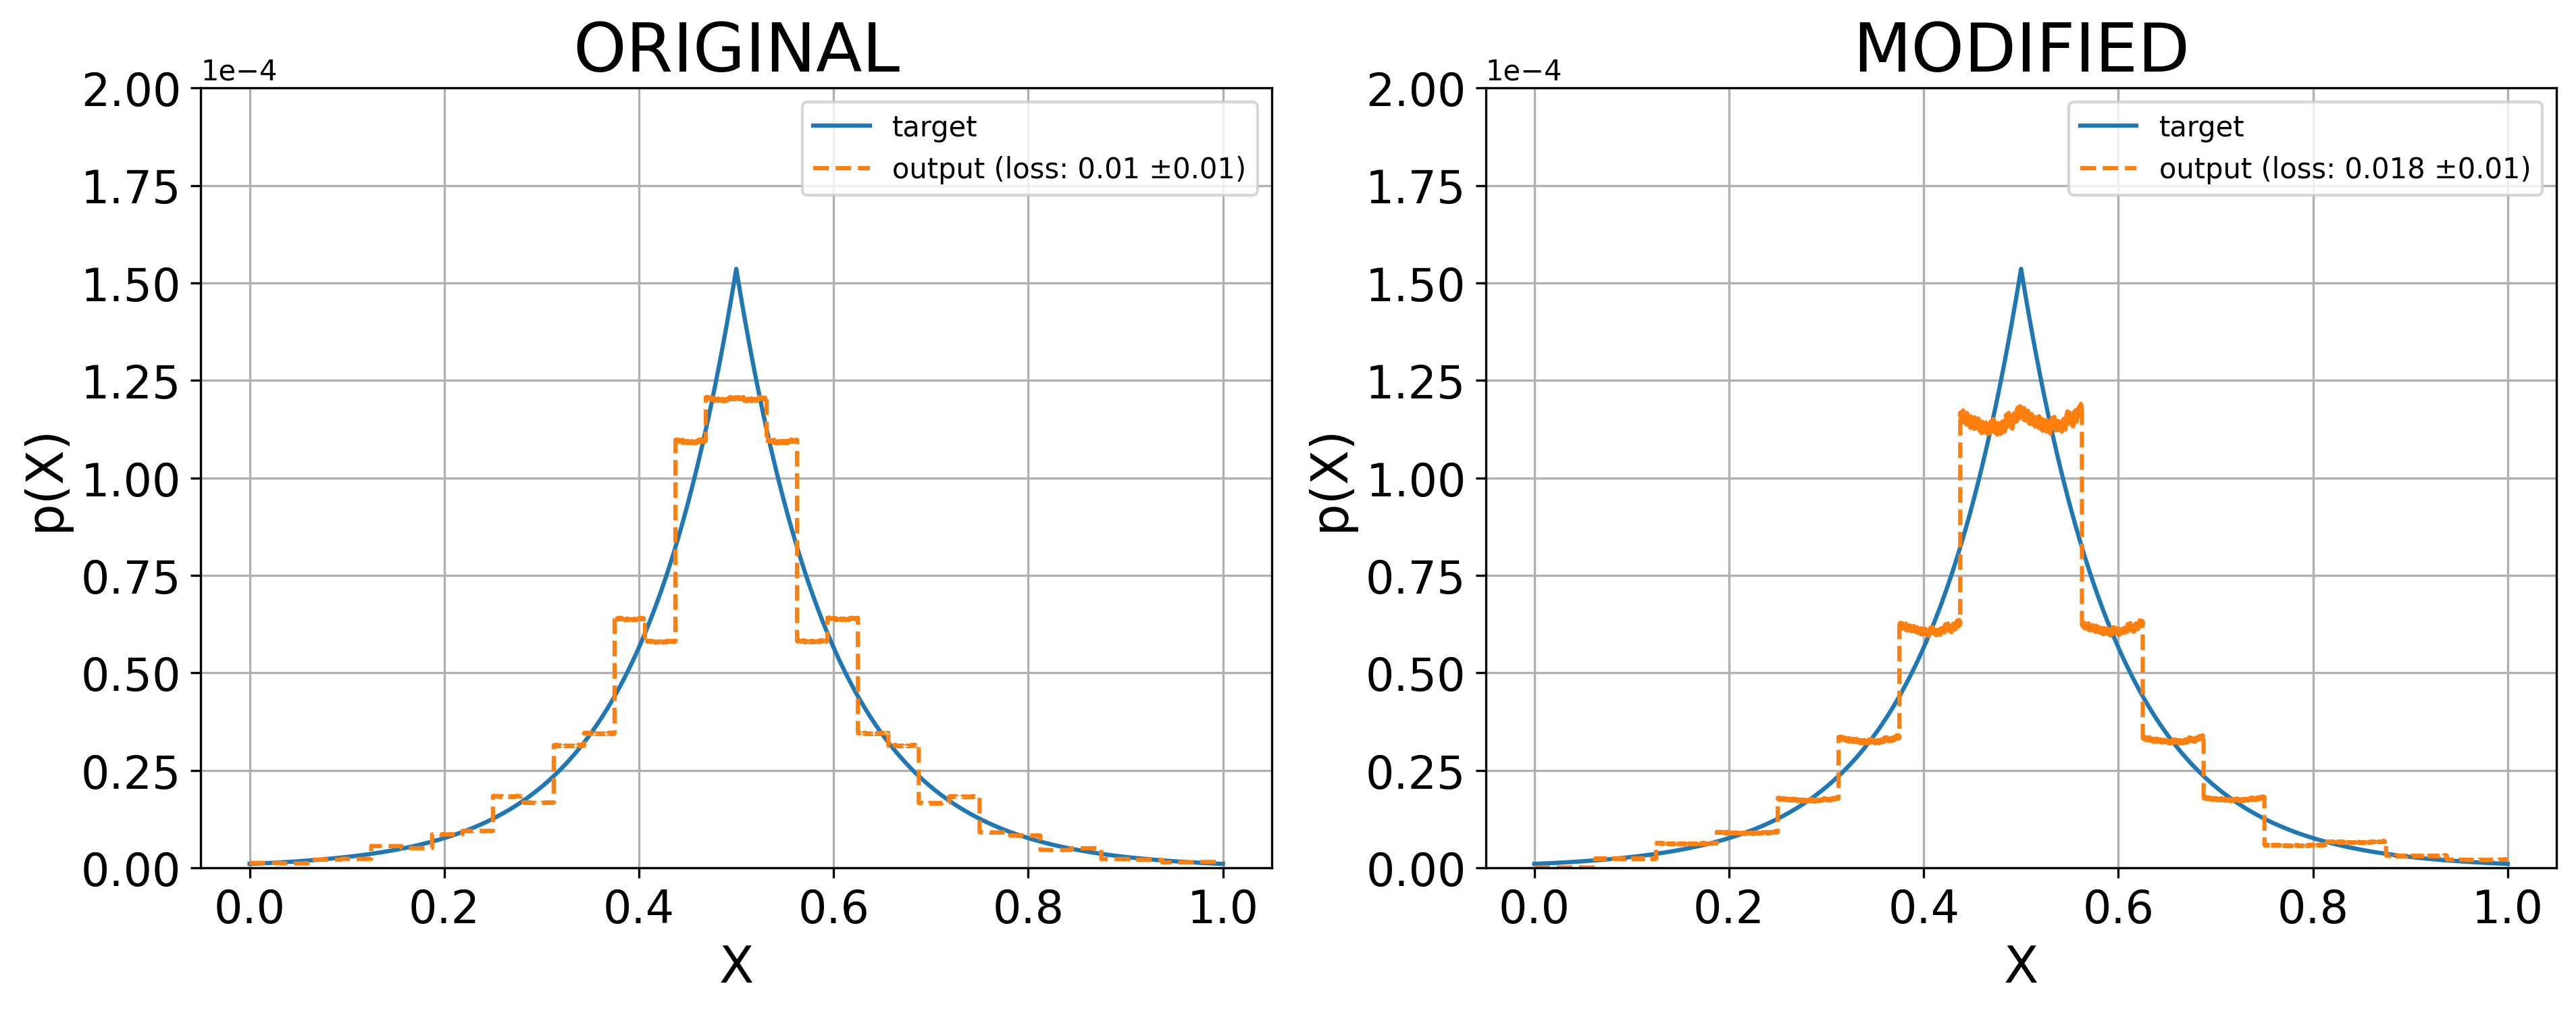

In [52]:
target_state = get_state(num_qubits=n_qubits, state_type=state_type, state_params={"x_points": (0, 1), "loc": 0.5, "scale": 0.2})


x_points = np.linspace(0, 1, 2**n_qubits)

target_freqs = np.abs(target_state)**2

#plt.ticklabel_format(axis="y", style="sci")
fig, axes = plt.subplots(1, 2, dpi=300)
fig.set_figheight(5)
fig.set_figwidth(15)
title_fontsize = 24
labels_fontsize= 18
ticks_fontsize = 16
axes[0].set_title("ORIGINAL", fontsize=title_fontsize)
axes[0].plot(x_points, target_freqs, label="target")
axes[0].plot(x_points, np.abs(sv_mean_original)**2, "--", label=f"output (loss: {round(df_mean_original.loc[n_qubits][eps_value], 3)} ±{round(df_stds_original.loc[n_qubits][eps_value], 2)})")
axes[0].grid()
axes[0].set_xlabel("X", fontsize=labels_fontsize)
axes[0].set_ylabel("p(X)", fontsize=labels_fontsize)
axes[0].tick_params(labelsize=ticks_fontsize)
axes[0].set_ylim([0, 0.0002])
axes[0].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
axes[0].legend(loc="best")

axes[1].set_title("MODIFIED", fontsize=title_fontsize)
axes[1].plot(x_points, target_freqs, label="target")
axes[1].plot(x_points, np.abs(sv_mean_modified)**2, "--", label=f"output (loss: {round(df_mean_modified.loc[n_qubits][eps_value], 3)} ±{round(df_stds_modified.loc[n_qubits][eps_value], 2)})")
axes[1].grid()
axes[1].set_xlabel("X", fontsize=labels_fontsize)
axes[1].set_ylabel("p(X)", fontsize=labels_fontsize)
axes[1].tick_params(labelsize=ticks_fontsize)
axes[1].set_ylim([0, 0.0002])
axes[1].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
axes[1].legend(loc="best")